**Short-term Memory**

In this coding session we'll implement a **short-term memory**, from a very basic solution to more advanced approaches.

In [2]:
import os
import os
os.environ["GROQ_API_KEY"] = "gsk_1HvkeGCnCs0fLV1m"
print("Groq key:", os.getenv("GROQ_API_KEY"))


Groq key: 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


Let's implement a very simple workflow to understand how the logic works. We'll start by creating a simple node that contains the LLM call.



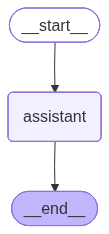

In [3]:
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage
from langgraph.graph import START,END,StateGraph
from IPython.display import Image,display

llm = ChatGroq(model = "llama-3.3-70b-versatile")

def assitant(state:MessagesState):
    return {"messages":llm.invoke(state["messages"])}

workflow = StateGraph(MessagesState)
workflow.add_node("assistant",assitant)
workflow.add_edge(START,"assistant")
workflow.add_edge("assistant",END)

graph = workflow.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))



In [4]:
messages = [HumanMessage(content="Hello,My Name is Taha")]
messages= graph.invoke({"messages":messages})

for message in messages["messages"]:
    message.pretty_print()


================================ Human Message =================================

Hello,My Name is Taha
================================== Ai Message ==================================

Hello Taha, it's nice to meet you. Is there something I can help you with or would you like to chat?


But ... what happens if I ask again my name?



In [5]:
message = [HumanMessage(content = "Remember my name")]
messages= graph.invoke({"messages":message})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Remember my name
================================== Ai Message ==================================

I don't have any record of your name. This is the beginning of our conversation, and I don't retain information from previous conversations. If you'd like to share your name, I'd be happy to address you by it during our conversation.


Did you guess it? Memory is not working for this Graph!

This is because state is transient to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions.

We can use persistence to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [23]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph_memory = workflow.compile(checkpointer=memory)

When we use memory, we need to specify a thread_id.

This thread_id will store our collection of graph states.

The checkpointer write the state at every step of the graph
These checkpoints are saved in a thread
We can access that thread in the future using the thread_id

In [24]:
config = {"configurable":{"thread_id":"1"}}

messages = [HumanMessage(content="Hello,My Name is Taha")]
result= graph_memory.invoke({"messages":messages},config=config)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello,My Name is Taha
================================== Ai Message ==================================

Hello Taha, it's nice to meet you. Is there something I can help you with or would you like to chat?


In [19]:
messages = [HumanMessage(content="Remember my name")]
result = graph_memory.invoke({"messages":messages},config=config)
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello,My Name is Taha
================================== Ai Message ==================================

Hello Taha, it's nice to meet you. Is there something I can help you with or would you like to chat?
================================ Human Message =================================

Remember my name
================================== Ai Message ==================================

I've got it, Taha. I'll remember your name for our conversation. How can I assist you today, Taha?
